# Hierarchical timeseries

In [1]:
# Disable warnings
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sktime.transformations.series.fourier import FourierFeatures
from sktime.forecasting.compose import ForecastingPipeline
from numpyro import distributions as dist

# Import dataset

Here we use the tourism dataset with state-level aggregation.

In [2]:
from sktime.transformations.hierarchical.aggregate import Aggregator

data = pd.read_csv("tourism.csv")

data["Quarter"] = pd.PeriodIndex(data["Quarter"], freq="Q")
data = data.set_index(["Region", "Purpose", "State", "Quarter"])[["Trips"]]
data = data.sort_index()

y = (
    Aggregator(flatten_single_levels=False)
    .fit_transform(data)
    .groupby(level=[1,  -1])
    .sum()
)
y

Trips
Purpose  Quarter              
Business 1998Q1    7391.962068
         1998Q2    7701.153191
         1998Q3    8911.852065
         1998Q4    7777.766525
         1999Q1    6917.257864
...                        ...
__total  2015Q4   51518.858354
         2016Q1   54984.720748
         2016Q2   49583.595515
         2016Q3   49392.159616
         2016Q4   54034.155613

[380 rows x 1 columns]

In [3]:
STATES = y.index.get_level_values(0).unique()

def plot_preds(y, preds={}, axs=None):
    
    if axs is None:
        fig, axs = plt.subplots(figsize=(12, 8), nrows=int(np.ceil(len(STATES)/2)), ncols=2)
        ax_generator = iter(axs.flatten())
    for state in STATES:
        ax = next(ax_generator)
        y.loc[state].iloc[:, 0].rename("Observation").plot(ax=ax, label="truth", color="black")
        for name, _preds in preds.items():
            _preds.loc[state].iloc[:, 0].rename(name).plot(ax=ax, legend=True)
        ax.set_title(state)
        
    # Tight layout
    plt.tight_layout()
    return ax

# Fit univariate model

Because of sktime's amazing interface, we can use the univariate Prophet seamlessly with hierarchical data. We do not reconcile it here, but it could be achieved with the `Reconciler` class.

In [5]:
from hierarchical_prophet.sktime.prophet import Prophet
model = Prophet(
    trend="logistic",
    changepoint_interval=8,
    changepoint_range=-8,
    changepoint_prior_scale=0.01,
    yearly_seasonality=True,
    weekly_seasonality=True,
    default_effect_mode="multiplicative",
    default_exogenous_prior=("Normal", 0, 0.01),
    # exogenous_effects={"sin": ("^sin_.*", LinearEffect("sin", effect_mode="multiplicative"))},
    noise_scale=0.05,
    mcmc_chains=1,
    mcmc_samples=300,
    mcmc_warmup=3000,
    optimizer_name="Adam",
    optimizer_kwargs={"step_size": 0.0001},
    inference_method="map",
    optimizer_steps=20000,
)
model.fit(y=y)

100%|██████████| 20000/20000 [00:01<00:00, 11998.36it/s, init loss: 7287.8613, avg. loss [19001-20000]: -298.7257]


Prophet(changepoint_interval=8, changepoint_prior_scale=0.01,
        changepoint_range=-8, default_exogenous_prior=('Normal', 0, 0.01),
        inference_method='map', mcmc_chains=1, mcmc_samples=300,
        mcmc_warmup=3000, optimizer_kwargs={'step_size': 0.0001},
        optimizer_steps=20000, trend='logistic', weekly_seasonality=True,
        yearly_seasonality=True)

## Forecasting

In [ ]:
y

Trips
Purpose  Quarter              
Business 1998Q1    7391.962068
         1998Q2    7701.153191
         1998Q3    8911.852065
         1998Q4    7777.766525
         1999Q1    6917.257864
...                        ...
__total  2015Q4   51518.858354
         2016Q1   54984.720748
         2016Q2   49583.595515
         2016Q3   49392.159616
         2016Q4   54034.155613

[380 rows x 1 columns]

<Axes: title={'center': '__total'}, xlabel='Quarter'>

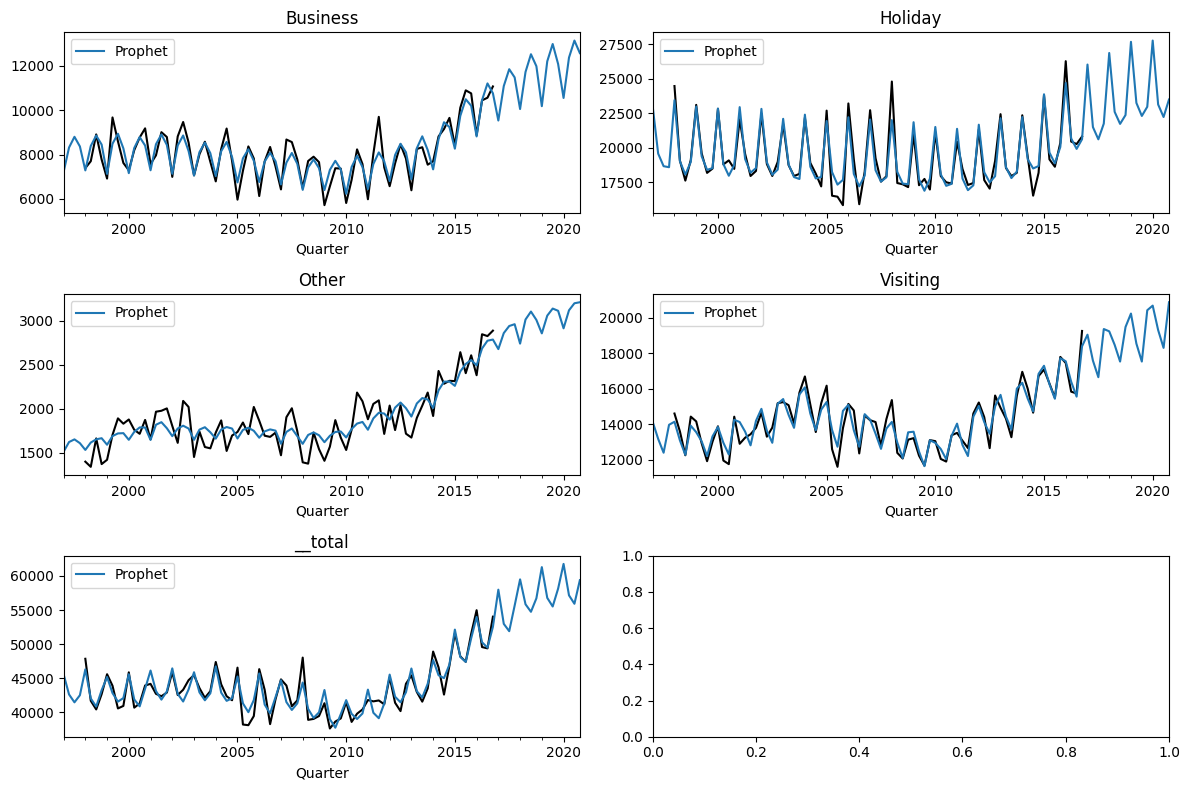

In [6]:
forecast_horizon = pd.period_range("1997Q1", "2020Q4", freq="Q")
preds = model.predict(fh=forecast_horizon)
plot_preds(y, {"Prophet": preds})

## Hierarchical Prophet

Now, let's use the hierarchical prophet to forecast all of the series at once. In addition, we will use the logistic growth model.

In [8]:
from hierarchical_prophet.sktime.multivariate import HierarchicalProphet
from hierarchical_prophet.effects import LinearEffect

model_hier = HierarchicalProphet(
    mcmc_chains=1,
    mcmc_samples=500,
    mcmc_warmup=3000,
    trend="logistic",
    changepoint_prior_scale=0.01,
    transformer_pipeline=FourierFeatures(fourier_terms_list=[4], sp_list=["Y"]),
    # shared_features=["^(sin).*", "^(cos).*"],
    changepoint_interval=10,
    changepoint_range=-8,
    noise_scale=0.05,
    exogenous_effects={
        "seasonality": (
            r"^(sin_|cos_).*",
            LinearEffect("sin", effect_mode="multiplicative", dist_args=(0, 10)),
        )
    },
    default_effect_mode="multiplicative",
    default_exogenous_prior=("Normal", 0, 10),
    optimizer_kwargs={"init_value": 1e-3, "decay_steps": 300_000, "alpha": 1e-5},
    # optimizer_kwargs={"step_size": 1e-4},
    optimizer_name="optax",
    inference_method="map",
    optimizer_steps=300_000,
    correlation_matrix_concentration=2,
)


model_hier.fit(y=y)

  6%|▋         | 19163/300000 [00:02<00:26, 10472.51it/s, init loss: 379149109690368.0000, avg. loss [1-15000]: 1242777255936.0000]

## Forecasting with hierarchical prophet

<Axes: title={'center': '__total'}, xlabel='Quarter'>

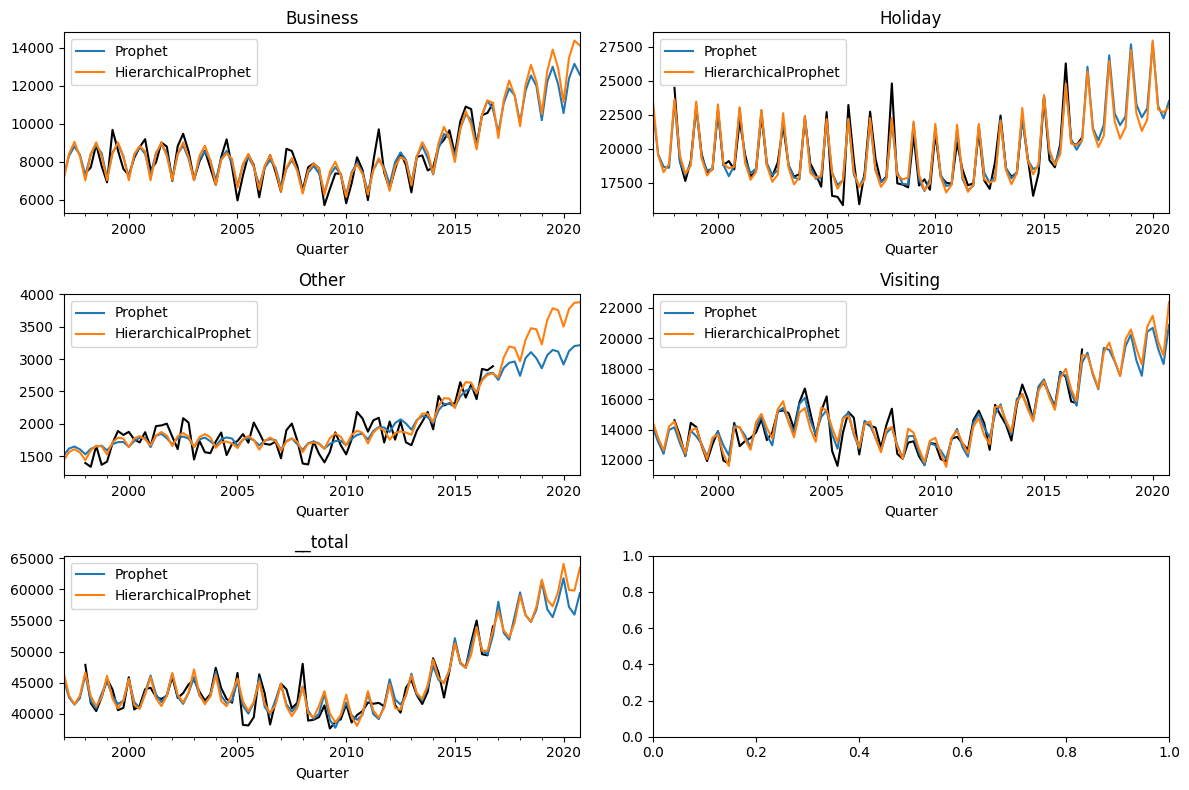

In [ ]:
preds_hier = model_hier.predict(fh=forecast_horizon)

plot_preds(
    y,
    preds={
        "Prophet": preds,
        "HierarchicalProphet": preds_hier,
    },
)

<Axes: title={'center': '__total'}, xlabel='Quarter'>

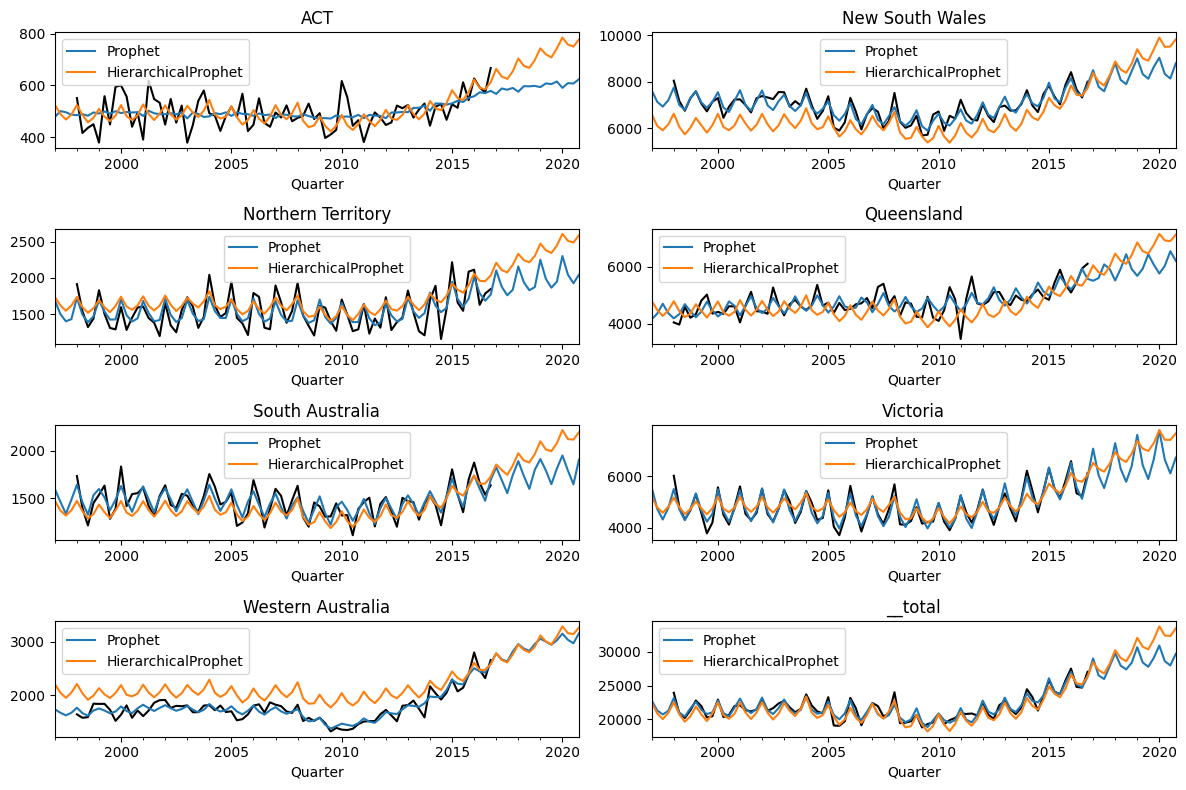

In [ ]:
preds_hier = model_hier.predict(fh=forecast_horizon)

plot_preds(
    y,
    preds={
        "Prophet": preds,
        "HierarchicalProphet": preds_hier,
    },
)

In [ ]:
model_hier.posterior_samples_["trend_"][:, -100]

Array([[0.7351751 ],
       [0.7352817 ],
       [0.73513025],
       [0.7351953 ],
       [0.7352041 ],
       [0.73517084],
       [0.73508877]], dtype=float32)